In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


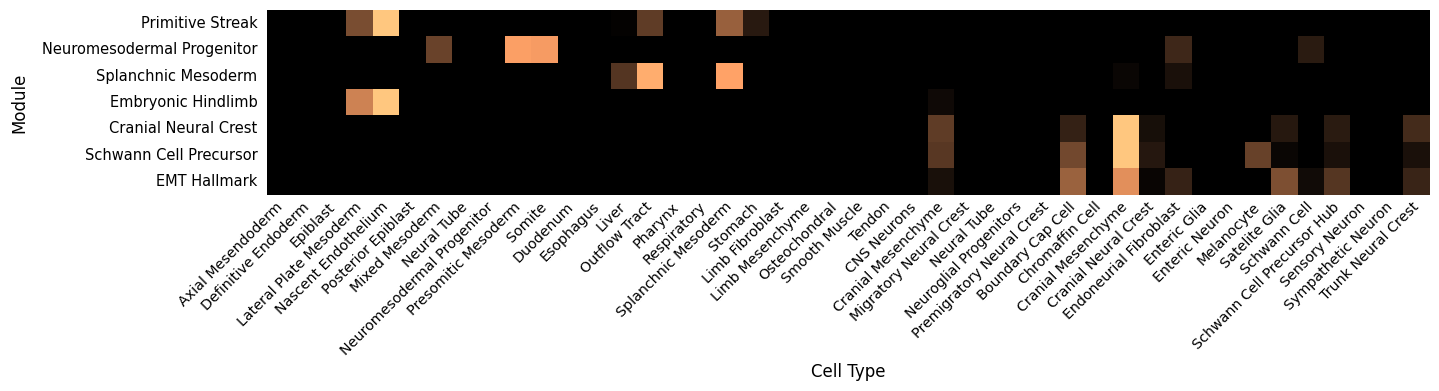

In [5]:
feat_plt = [
    'GSE162534',
    'GSE229103',
    'GSE136689',
    'HCAEmbryonicHindlimb',
    'rRNAModifications',
    'GSE201257',
    'EMTHallmark']

msk = (adata.obs.celltype != 'nan')
df_plt = (adata[msk].obs.groupby(
          ['source', 'celltype'], observed = True)[feat_plt]
          .mean().T)
for ix in df_plt.index: df_plt.loc[ix] = zscore(df_plt.loc[ix])
df_plt = df_plt.loc[:, feat_plt[:-1]]
df_plt.columns = df_plt.columns.get_level_values(1)
df_plt.index = df.loc[df_plt.index].Name

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
hm = sns.heatmap(
    df_plt,
    cmap = 'copper',
    vmin = 1,
    vmax = 3,
    square = True,
    cbar = False,
    ax = ax)

ax.set_xlabel('Cell Type', size = 12)
ax.set_ylabel('Module', size = 12, labelpad = 10)
ax.tick_params(size = 0, pad = 7, labelsize = 10.5)
ax.set_xticklabels(ax.get_xticklabels(),
                   size = 10.25, rotation = 45,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
fn = os.path.join(pth_out, 'heatmap.pdf')
plt.savefig(fn, bbox_inches = 'tight')